# Example: Trefoil Knot

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx

import dyneusr as ds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

## Load data

In [4]:
from load_data import load_trefoil, Bunch
from load_data import scatter3d, tsplot, plt

# load data
data, = load_trefoil(size=100)

INFO:load_data:load_trefoil(size=100, noise=[0.0], y_bins=3)
INFO:root:...gen_trefoil(size=100, noise=0.0)
INFO:load_data:dataset.keys() = dict_keys(['X', 'y', 'bins', 'index', 'cmap', 'norm'])
INFO:load_data:Splitting dataset...
INFO:load_data:dataset = [<class 'sklearn.utils.Bunch'>]


### Visual inspection of data, meta

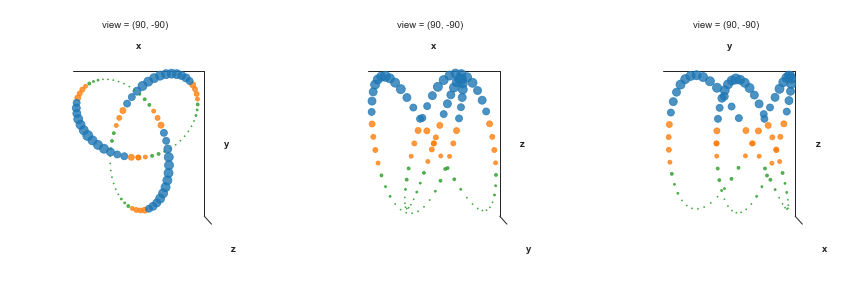

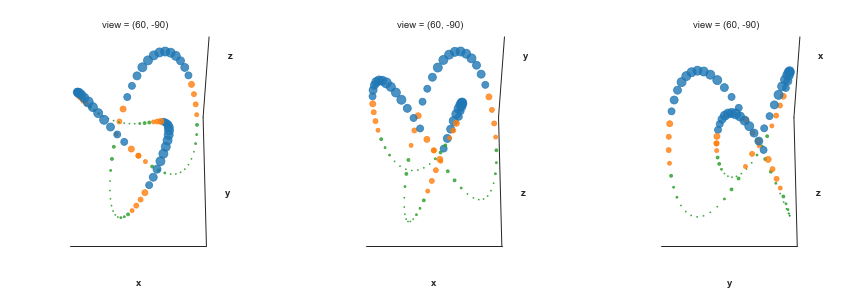

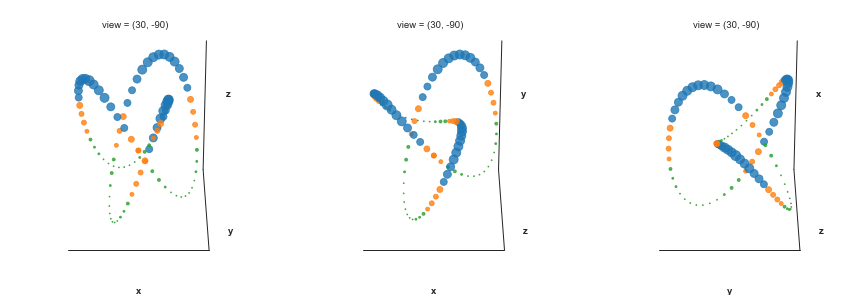

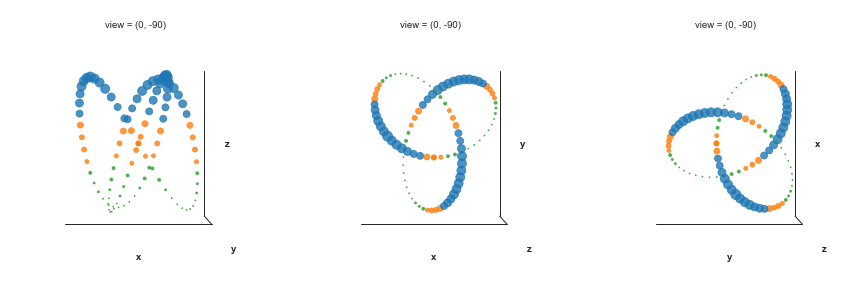

In [5]:
# visualize
_ = scatter3d(X=data.X, c=data.y, norm=data.norm, cmap=data.cmap)
_ = scatter3d(X=data.X, c=data.y, norm=data.norm, cmap=data.cmap, view=(60, -90))
_ = scatter3d(X=data.X, c=data.y, norm=data.norm, cmap=data.cmap, view=(30, -90))
_ = scatter3d(X=data.X, c=data.y, norm=data.norm, cmap=data.cmap, view=(0, -90))

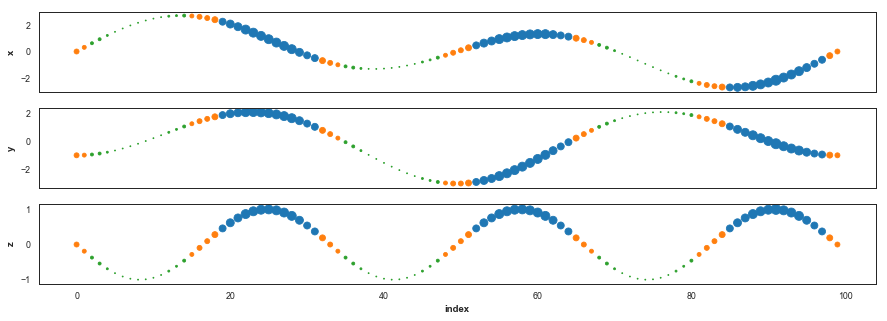

In [6]:
_ = tsplot(X=data.X, y=data.y)


## Generate $MAPPER$ graph

In [7]:
# define inputs: X=data, y=meta
X = data.X
X_inverse = data.X
y = data.y

In [8]:
import kmapper as km

# init MAPPER
mapper = km.KeplerMapper(verbose=1)

# init MAPPER params
projection = [0, 1]
clusterer = km.cluster.KMeans(2)
cover = km.Cover(6, 0.8)

KeplerMapper()


In [9]:
# run MAPPER
lens = mapper.fit_transform(X, projection=projection)
graph = mapper.map(lens, X_inverse, clusterer, cover)

# cache parameters, results for later
mapped = Bunch(X=X, lens=lens, graph=graph, clusterer=clusterer, cover=cover)

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (100, 3)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (100, 3) using lens shaped (100, 2)

Creating 36 hypercubes.

Created 123 edges and 68 nodes in 0:00:00.428123.


### Visual inspection of lens

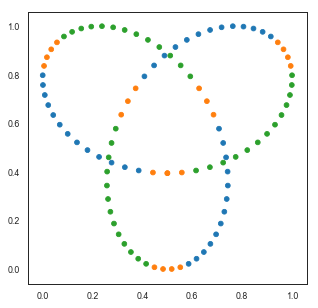

In [10]:
# plot
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(*lens.T, c=y, cmap=data.cmap, norm=data.norm)

## Fit a `DyNeuGraph` to the $MAPPER$ graph

In [11]:
# fit DyNeuGraph to MAPPER graph
dG = ds.DyNeuGraph()
dG.fit(graph, y=y)

# show shape of map_ (dimensions: nodes x members)
print(dG.map_.shape)

Found 3 unique groups.
1.0
(100, 68)


### Visual inspection of nx.Graph object

(<matplotlib.collections.PathCollection at 0x1069c4240>,
 <matplotlib.collections.LineCollection at 0x11fb85dd8>)

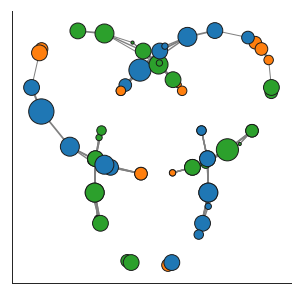

In [12]:
from collections import Counter
# colors, size for nodes
node_size = [10*len(y[dG.G_.nodes[n]['members']])**2 for n in dG.G_]
node_color = [Counter(y[dG.G_.nodes[n]['members']]).most_common()[0][0] for n in dG.G_]
node_color = [data.cmap(data.norm(_)) for _ in node_color]

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos="inverse", layout=None, ax=ax, 
    node_color=node_color, node_size=node_size
    )

## Visualize $MAPPER$ steps

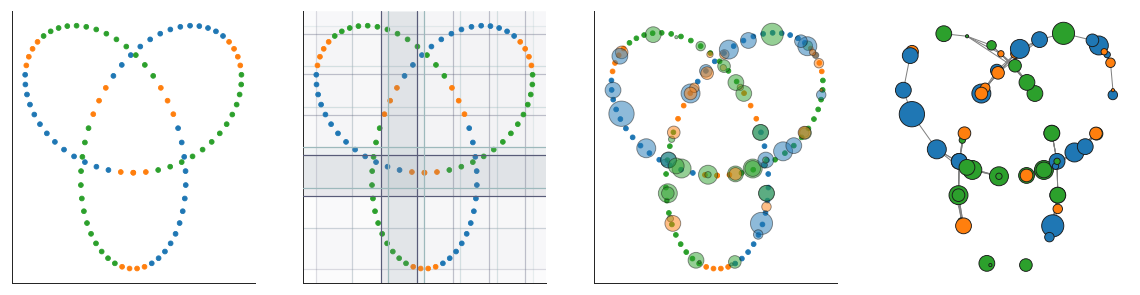

In [13]:
from dyneusr.tools.networkx_utils import format_nx, draw_nx, despine
from dyneusr.tools.networkx_utils import get_cover_cubes, draw_cover

fig, ax = plt.subplots(1, 4, figsize=(20,5))
cmap = data.cmap
norm = data.norm

# colors, size for nodes
node_size = [10*len(y[dG.G_.nodes[n]['members']])**2 for n in dG.G_]
node_color = [Counter(y[dG.G_.nodes[n]['members']]).most_common()[0][0] for n in dG.G_]
node_color = [data.cmap(data.norm(_)) for _ in node_color]


# [1] draw lens
ax[0].scatter(*lens.T, c=y, cmap=cmap, norm=norm)


# [2] draw lens with cover
ax[1].scatter(*lens.T,  c=y, cmap=cmap, norm=norm)
_ = draw_cover(ax=ax[1], graph=graph, lens=lens, cover=mapped.cover)


# [3] draw clusters
ax[2].scatter(*lens.T, c=y, cmap=cmap, norm=norm)
_ = draw_nx(graph, meta=y, lens=lens, pos="inverse", layout=None, 
            node_color=node_color, node_size=node_size, 
            cmap=cmap, norm=norm, alpha=0.5,
            edges=False, ax=ax[2])


# [4] draw shape graph
_ = draw_nx(graph, meta=y, lens=lens, pos="inverse", layout=None, 
            node_color=node_color, node_size=node_size, 
            edge_color='gray', width=1, ax=ax[3])
ax[3].axis('off')


# finish
for _ in ax:
    despine(_)


### Plot Temporal Connectivity Matrix (TCM)

Saving figure, save_as: results/tcm_degree.png


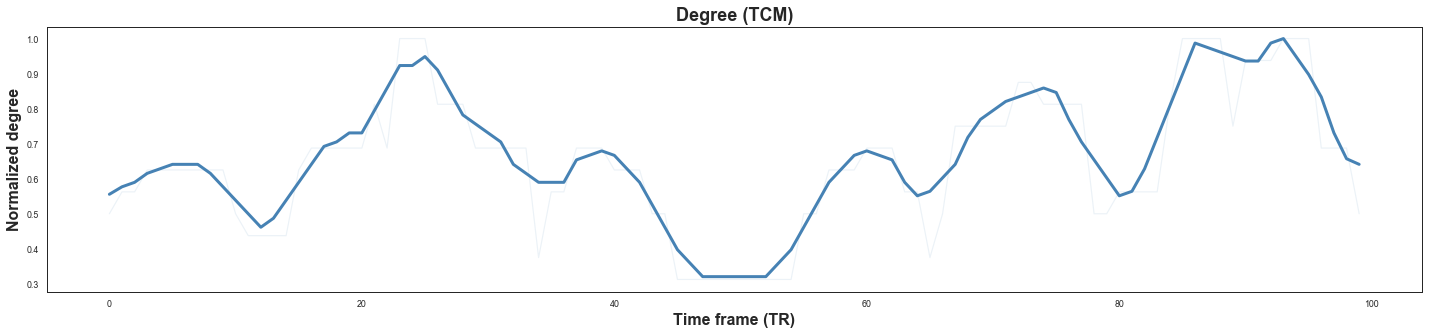

In [14]:
# plot normalized TCM
tcm_image = ds.visuals.plot_temporal_degree(
    dG.tcm_, window=5, show=True, save_as='results/tcm_degree.png'
)

In [15]:
# annotate dG with images
_ = dG.annotate(image=tcm_image)

## Visualize `DyNeuGraph`

In [16]:
%%script bash --bg

python3 -m http.server 8881

Starting job # 0 in a separate thread.


In [17]:
_ = dG.visualize('trefoil_knot.html', path_assets='results', show=True, PORT=8881)

1
2
3
[Force Graph] http://localhost:8881/trefoil_knot.html


<Figure size 432x288 with 0 Axes>